Dimensionality Rediction

In [ ]:
import kagglehub

# Load the dataset directly (does not require manual downloading)
dataset_path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Dataset stored at:", dataset_path)


Dataset stored at: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [ ]:
import pandas as pd

# Define paths to CSV files
train_path = dataset_path + "/fashion-mnist_train.csv"
test_path = dataset_path + "/fashion-mnist_test.csv"

# Load the dataset into Pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Print first few rows to verify
print(train_df.head())


   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [ ]:
# Extract features and labels
y_train = train_df.iloc[:, 0].values  # Labels (0-9)
X_train = train_df.iloc[:, 1:].values  # Pixel values
y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train, y_train)
train_time_original = time.time() - start_time

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)
print(f"Original XGBoost Accuracy: {accuracy_original:.4f}")

# Measure inference time
start_time = time.time()
y_pred = xgb_model.predict(X_test)
inference_time_orig = time.time() - start_time

# Calculate accuracy
accuracy_orig = accuracy_score(y_test, y_pred)

print(f"Original Random Forest Accuracy: {accuracy_orig:.4f}")
print(f"Training Time: {train_time_original:.2f} sec")
print(f"Inference Time: {inference_time_orig:.2f} sec")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Original XGBoost Accuracy: 0.8970
Original Random Forest Accuracy: 0.8970
Training Time: 117.31 sec
Inference Time: 0.38 sec


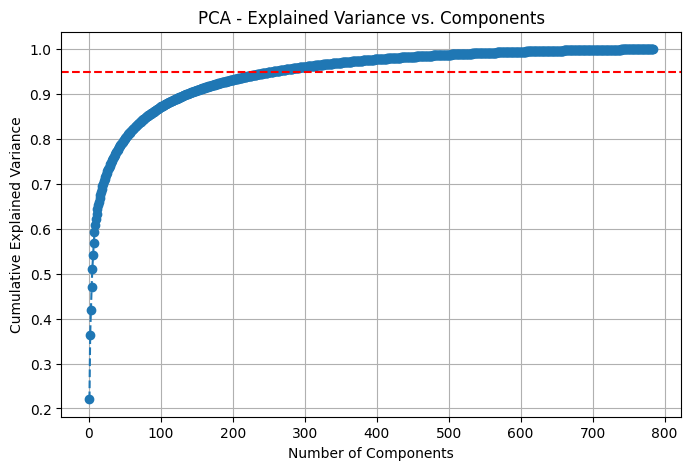

Optimal n_components: 137


In [ ]:
 # Apply PCA and find the explained variance
pca = PCA().fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 785), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs. Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold
plt.grid()
plt.show()

# Pick n_components that explains 95% of variance
n_components = np.argmax(explained_variance >= 0.9) + 1
print(f"Optimal n_components: {n_components}")


In [ ]:
# Apply PCA with optimal n_components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train xgb with PCA data
xgb_pca =  xgb.XGBClassifier(n_estimators=100, random_state=42)

# Measure training time
start_time = time.time()
xgb_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_time

# Measure inference time
start_time = time.time()
y_pred_pca = xgb_pca.predict(X_test_pca)
inference_time_pca = time.time() - start_time

# Calculate accuracy
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"XGBoost with PCA Accuracy: {accuracy_pca:.4f}")
print(f"Training Time: {train_time_pca:.2f} sec")
print(f"Inference Time: {inference_time_pca:.2f} sec")


XGBoost with PCA Accuracy: 0.8854
Training Time: 100.36 sec
Inference Time: 0.25 sec



📊 **Performance Comparison**
Original Random Forest Accuracy: 0.8970 | Training Time: 117.31 sec | Inference Time: 0.38 sec
Random Forest with PCA Accuracy: 0.8854 | Training Time: 100.36 sec | Inference Time: 0.25 sec


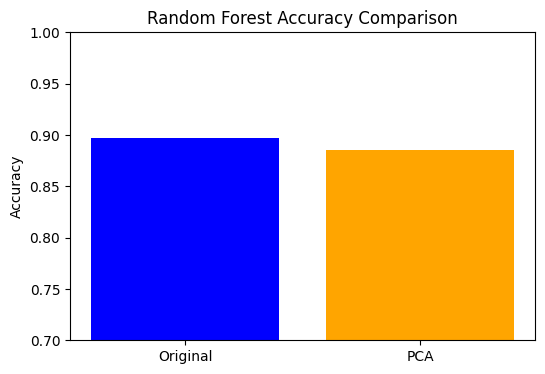

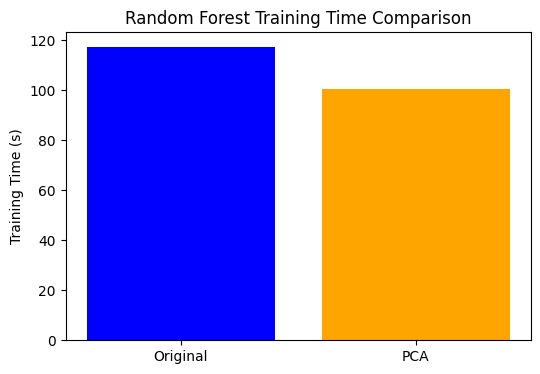

In [ ]:
print("\n📊 **Performance Comparison**")
print(f"Original Random Forest Accuracy: {accuracy_orig:.4f} | Training Time: {train_time_orig:.2f} sec | Inference Time: {inference_time_orig:.2f} sec")
print(f"Random Forest with PCA Accuracy: {accuracy_pca:.4f} | Training Time: {train_time_pca:.2f} sec | Inference Time: {inference_time_pca:.2f} sec")

# Plot accuracy comparison
plt.figure(figsize=(6,4))
plt.bar(['Original', 'PCA'], [accuracy_orig, accuracy_pca], color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Comparison')
plt.ylim(0.7, 1.0)
plt.show()

# Plot time comparison
plt.figure(figsize=(6,4))
plt.bar(['Original', 'PCA'], [train_time_orig, train_time_pca], color=['blue', 'orange'])
plt.ylabel('Training Time (s)')
plt.title('Random Forest Training Time Comparison')
plt.show()


k-means

In [ ]:
# Load the dataset directly (does not require manual downloading)
dataset_path = kagglehub.dataset_download("uciml/iris")

print("Dataset stored at:", dataset_path)

100%|██████████| 3.60k/3.60k [00:00<00:00, 3.58MB/s]

Extracting files...
Dataset stored at: /root/.cache/kagglehub/datasets/uciml/iris/versions/2


In [ ]:
# Define paths to CSV files
data_path = dataset_path + "/Iris.csv"

# Load the dataset into Pandas DataFrames
df = pd.read_csv(data_path)

# Print first few rows to verify
print(df.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Transform 'Species' column
species_encoded = encoder.fit_transform(df[['Species']])

# Convert to DataFrame
species_df = pd.DataFrame(species_encoded, columns=encoder.get_feature_names_out(['Species']))

# Concatenate with original DataFrame
df_final = pd.concat([df.drop(columns=['Species']), species_df], axis=1)

print(df_final.head())


   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0   1            5.1           3.5            1.4           0.2   
1   2            4.9           3.0            1.4           0.2   
2   3            4.7           3.2            1.3           0.2   
3   4            4.6           3.1            1.5           0.2   
4   5            5.0           3.6            1.4           0.2   

   Species_Iris-setosa  Species_Iris-versicolor  Species_Iris-virginica  
0                  1.0                      0.0                     0.0  
1                  1.0                      0.0                     0.0  
2                  1.0                      0.0                     0.0  
3                  1.0                      0.0                     0.0  
4                  1.0                      0.0                     0.0  


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Apply scaling
df_scaled = df_final.copy()  # Make a copy of the DataFrame
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

print(df_scaled.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0   1      -0.900681      1.032057      -1.341272     -1.312977   
1   2      -1.143017     -0.124958      -1.341272     -1.312977   
2   3      -1.385353      0.337848      -1.398138     -1.312977   
3   4      -1.506521      0.106445      -1.284407     -1.312977   
4   5      -1.021849      1.263460      -1.341272     -1.312977   

   Species_Iris-setosa  Species_Iris-versicolor  Species_Iris-virginica  
0                  1.0                      0.0                     0.0  
1                  1.0                      0.0                     0.0  
2                  1.0                      0.0                     0.0  
3                  1.0                      0.0                     0.0  
4                  1.0                      0.0                     0.0  


In [ ]:
from sklearn.cluster import KMeans

# Define number of clusters (e.g., 3 for the 3 species in Iris dataset)
k = 3

# Apply K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']])

# Print results
print(df_scaled[['Id', 'Cluster']].head())  # Show first few rows with clusters


   Id  Cluster
0   1        1
1   2        1
2   3        1
3   4        1
4   5        1


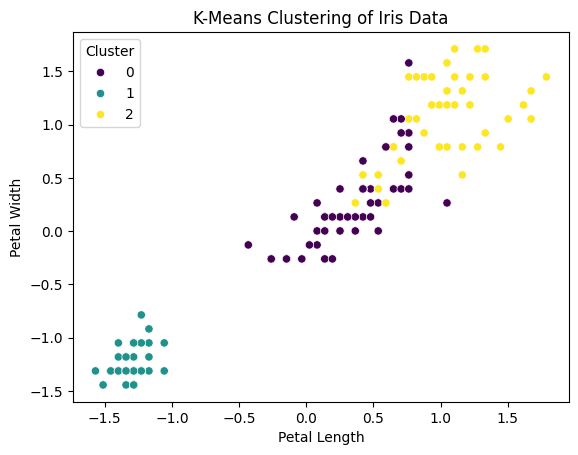

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=df_scaled['PetalLengthCm'], y=df_scaled['PetalWidthCm'], hue=df_scaled['Cluster'], palette='viridis')
plt.title("K-Means Clustering of Iris Data")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()


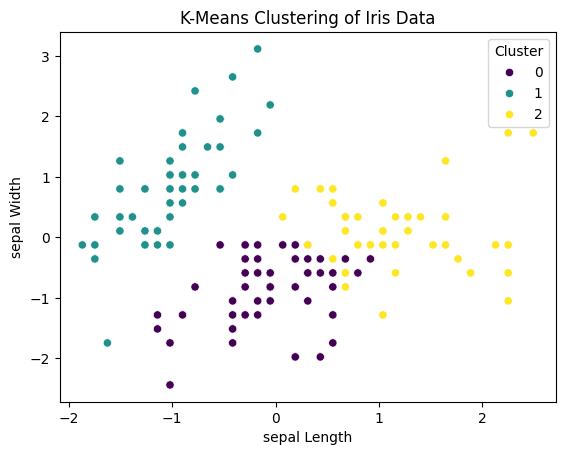

In [ ]:
sns.scatterplot(x=df_scaled['SepalLengthCm'], y=df_scaled['SepalWidthCm'], hue=df_scaled['Cluster'], palette='viridis')
plt.title("K-Means Clustering of Iris Data")
plt.xlabel("sepal Length")
plt.ylabel("sepal Width")
plt.show()

Feature Selection

In [2]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,uid,day,hour,minute,C_motion,feed_water_motion,faucet_hole,vapour_pressure,vapour_enthalpy,vapour_pressure_at_division,vapour_motion,feed_water_enth,vapour_temperature,output_electricity_generation
0,0,Saturday,7.0,NaN,387.374315,2681.205431,0.678352,25.050893,2775.784134,26.465138,2682.758692,1289.082351,601.850322,974.182544
1,1,Saturday,12.0,28.0,238.153011,1604.213100,0.679706,15.241147,2903.619864,NaN,1602.318002,1144.454102,603.933579,593.915516
2,2,Friday,15.0,13.0,338.270228,2398.561685,0.662971,23.078376,2796.443584,24.316160,NaN,1258.098883,602.443281,884.033450
3,3,Saturday,14.0,NaN,254.294492,1620.034059,0.679977,15.054982,2818.023511,15.895513,1619.387667,1142.463833,588.938717,584.908719
4,4,Saturday,18.0,16.0,203.189410,1485.672389,0.686342,12.963420,2816.144355,13.682371,1487.685052,1099.539481,504.208816,483.609973


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uid                            50400 non-null  int64  
 1   day                            44921 non-null  object 
 2   hour                           44787 non-null  float64
 3   minute                         44930 non-null  float64
 4   C_motion                       44883 non-null  float64
 5   feed_water_motion              44803 non-null  float64
 6   faucet_hole                    44834 non-null  float64
 7   vapour_pressure                44921 non-null  float64
 8   vapour_enthalpy                44963 non-null  float64
 9   vapour_pressure_at_division    44923 non-null  float64
 10  vapour_motion                  44923 non-null  float64
 11  feed_water_enth                44904 non-null  float64
 12  vapour_temperature             44883 non-null 

In [4]:
df.isna().sum()

,0
uid,0
day,5479
hour,5613
minute,5470
C_motion,5517
feed_water_motion,5597
faucet_hole,5566
vapour_pressure,5479
vapour_enthalpy,5437
vapour_pressure_at_division,5477


In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Load your dataset (assuming df is already available)
df = df.replace('?', np.nan)  # Replace '?' with NaN if needed

# Convert 'day' categorical column into numerical format
if df['day'].dtype == 'object':  # Ensure it's categorical before encoding
    le = LabelEncoder()
    df['day'] = le.fit_transform(df['day'])  # 'Friday' → 0, 'Saturday' → 1

# Define the XGBoost imputer
xgb_imputer = IterativeImputer(estimator=XGBRegressor(objective="reg:squarederror", random_state=42),
                               max_iter=10, initial_strategy="median")

# Apply imputation
df_imputed = pd.DataFrame(xgb_imputer.fit_transform(df), columns=df.columns)

# Ensure categorical column 'day' is rounded since it's categorical
df_imputed['day'] = df_imputed['day'].round().astype(int)  # Assuming day should be an integer category

# Print the count of remaining NaN values
print("Missing values after imputation:\n", df_imputed.isna().sum())


Missing values after imputation:
 uid                              0
day                              0
hour                             0
minute                           0
C_motion                         0
feed_water_motion                0
faucet_hole                      0
vapour_pressure                  0
vapour_enthalpy                  0
vapour_pressure_at_division      0
vapour_motion                    0
feed_water_enth                  0
vapour_temperature               0
output_electricity_generation    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uid                            50400 non-null  int64  
 1   day                            50400 non-null  int64  
 2   hour                           44787 non-null  float64
 3   minute                         44930 non-null  float64
 4   C_motion                       44883 non-null  float64
 5   feed_water_motion              44803 non-null  float64
 6   faucet_hole                    44834 non-null  float64
 7   vapour_pressure                44921 non-null  float64
 8   vapour_enthalpy                44963 non-null  float64
 9   vapour_pressure_at_division    44923 non-null  float64
 10  vapour_motion                  44923 non-null  float64
 11  feed_water_enth                44904 non-null  float64
 12  vapour_temperature             44883 non-null 

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
df.columns

Index(['uid', 'day', 'hour', 'minute', 'C_motion', 'feed_water_motion',
       'faucet_hole', 'vapour_pressure', 'vapour_enthalpy',
       'vapour_pressure_at_division', 'vapour_motion', 'feed_water_enth',
       'vapour_temperature', 'output_electricity_generation'],
      dtype='object')

In [9]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
std_scaler = StandardScaler()
scaled_feats = std_scaler.fit_transform(df_imputed)

poly_feat_creator = PolynomialFeatures(degree=2, include_bias=False)
poly_feat = poly_feat_creator.fit_transform(scaled_feats)

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder

# Separate features and target variable
X = df_imputed.drop(columns=['output_electricity_generation', 'uid'])  # Drop ID and target
y = df_imputed['output_electricity_generation']

# Generate polynomial features (degree=2 for interactions, increase if needed)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

# Scale the polynomial features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Convert back to DataFrame
poly_feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly_scaled, columns=poly_feature_names)

# Display transformed dataset
print("Polynomial Features Shape:", X_poly_df.shape)
X_poly_df.head()

Polynomial Features Shape: (50400, 90)


,day,hour,minute,C_motion,feed_water_motion,faucet_hole,vapour_pressure,vapour_enthalpy,vapour_pressure_at_division,vapour_motion,...,vapour_pressure_at_division^2,vapour_pressure_at_division vapour_motion,vapour_pressure_at_division feed_water_enth,vapour_pressure_at_division vapour_temperature,vapour_motion^2,vapour_motion feed_water_enth,vapour_motion vapour_temperature,feed_water_enth^2,feed_water_enth vapour_temperature,vapour_temperature^2
0,0.477395,-0.812677,-1.225078,0.695218,0.875399,0.626077,0.584648,-0.715024,0.596368,0.650875,...,0.317231,0.339390,0.214783,0.579047,0.351307,0.231401,0.631243,0.072727,0.264021,0.298786
1,0.477395,0.016909,-0.072483,-1.087803,-1.524991,0.745598,-1.185624,2.517054,-1.187272,-1.240677,...,-0.699435,-0.714386,-0.511649,-1.066490,-0.711547,-0.520922,-1.110711,-0.240710,-0.259033,0.373957
2,-1.042549,0.514661,-0.948984,0.108481,0.245445,-0.731957,0.228687,-0.192690,0.226271,0.150723,...,0.065607,0.042956,0.051544,0.239584,0.018151,0.026459,0.172097,0.002444,0.153421,0.320155
3,0.477395,0.348743,0.708394,-0.894931,-1.489729,0.769477,-1.219219,0.352917,-1.223935,-1.210792,...,-0.715145,-0.716013,-0.524401,-1.163879,-0.698922,-0.513368,-1.148337,-0.244764,-0.372300,-0.161318
4,0.477395,1.012412,-0.773684,-1.505578,-1.789193,1.331496,-1.596664,0.305406,-1.605083,-1.441367,...,-0.866080,-0.841610,-0.668745,-1.817541,-0.792864,-0.612622,-1.696607,-0.330468,-1.104076,-2.933083


In [11]:
X_poly_df.columns

Index(['day', 'hour', 'minute', 'C_motion', 'feed_water_motion', 'faucet_hole',
       'vapour_pressure', 'vapour_enthalpy', 'vapour_pressure_at_division',
       'vapour_motion', 'feed_water_enth', 'vapour_temperature', 'day^2',
       'day hour', 'day minute', 'day C_motion', 'day feed_water_motion',
       'day faucet_hole', 'day vapour_pressure', 'day vapour_enthalpy',
       'day vapour_pressure_at_division', 'day vapour_motion',
       'day feed_water_enth', 'day vapour_temperature', 'hour^2',
       'hour minute', 'hour C_motion', 'hour feed_water_motion',
       'hour faucet_hole', 'hour vapour_pressure', 'hour vapour_enthalpy',
       'hour vapour_pressure_at_division', 'hour vapour_motion',
       'hour feed_water_enth', 'hour vapour_temperature', 'minute^2',
       'minute C_motion', 'minute feed_water_motion', 'minute faucet_hole',
       'minute vapour_pressure', 'minute vapour_enthalpy',
       'minute vapour_pressure_at_division', 'minute vapour_motion',
       'minute f

In [13]:
#XGBoost without any Dimensionality reduction

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 1.3107


In [15]:
#XGBoost with PCA

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Apply PCA
n_components = 10  # Adjust based on explained variance
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_poly_df)

# Split the PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE after PCA: {rmse:.4f}")

# Check explained variance to understand how much data is retained
explained_variance = sum(pca.explained_variance_ratio_) * 100
print(f"Explained Variance with {n_components} components: {explained_variance:.2f}%")


Test RMSE after PCA: 4.2838
Explained Variance with 10 components: 98.81%


In [17]:
#XGBoost with Variance Thresholding

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Apply Variance Thresholding
threshold = 0.01  # Set a variance threshold, can be adjusted
selector = VarianceThreshold(threshold=threshold)
X_var = selector.fit_transform(X_poly_df)

# Get selected feature names
selected_features = X_poly_df.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features after Variance Thresholding")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_var, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE after Variance Thresholding: {rmse:.4f}")


Selected 90 features after Variance Thresholding
Test RMSE after Variance Thresholding: 1.3107


In [25]:
#XGBoost with Correlation based Filtering


import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Compute the correlation matrix
correlation_matrix = X_poly_df.corr().abs()

# Set a threshold for correlation (e.g., 0.85)
corr_threshold = 0.85

# Identify highly correlated features
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]

# Drop highly correlated features
X_corr_filtered = X_poly_df.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features")

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_corr_filtered, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE after Correlation Filtering: {rmse:.4f}")


Removed 76 highly correlated features
Test RMSE after Correlation Filtering: 1.5277


In [19]:
#XGBoost with ANOVA

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Apply ANOVA F-test feature selection
k_best = 10  # Number of top features to keep, adjust as needed
anova_selector = SelectKBest(score_func=f_regression, k=k_best)
X_anova = anova_selector.fit_transform(X_poly_df, y)

# Get selected feature names
selected_features = X_poly_df.columns[anova_selector.get_support()]
print(f"Selected {len(selected_features)} features using ANOVA")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_anova, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE after ANOVA Feature Selection: {rmse:.4f}")


Selected 10 features using ANOVA
Test RMSE after ANOVA Feature Selection: 2.4314


In [21]:
#XGBoost with MI

from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Apply Mutual Information feature selection
k_best = 10  # Select top k features, adjust as needed
mi_selector = SelectKBest(score_func=mutual_info_regression, k=k_best)
X_mi = mi_selector.fit_transform(X_poly_df, y)

# Get selected feature names
selected_features = X_poly_df.columns[mi_selector.get_support()]
print(f"Selected {len(selected_features)} features using Mutual Information")

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_mi, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE after Mutual Information Feature Selection: {rmse:.4f}")


Selected 10 features using Mutual Information
Test RMSE after Mutual Information Feature Selection: 7.5162


In [ ]:
#XGBoost with greedy selection

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Define number of features to keep
num_features_to_keep = 10  # Adjust based on dataset size

# Perform Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=num_features_to_keep)
X_rfe = rfe_selector.fit_transform(X_poly_df, y)

# Get selected feature names
selected_features = X_poly_df.columns[rfe_selector.support_]
print(f"Selected {len(selected_features)} features using Greedy Selection")

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Train XGBoost model with selected features
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)



In [23]:
# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE after Greedy Feature Selection: {rmse:.4f}")


Test RMSE after Greedy Feature Selection: 1.6916


Findings:

After using a simple XGBoost regressor on the data set the rmse of the predictions were:


1.   1.3107: no dim red technique
1.   4.2838: PCA
1.   1.3107: Variance Thresholding (no columns dropped)
2.   1.5277: Correlation Filtering
2.   2.4314: ANOVA
2.   7.5162: Mutual Information
7.   1.6916: Greedy Selection

In this scenerio, Correlation Filtering and Greedy Selection seem like the best options for Dimension Reduction

